# Recommendation System Project: Matching System AuPair

No KitKats?

By Santanam Wishal for Garuda Hacks 6.0

In [2]:
!pip install "numpy<2"
!pip install scikit-surprise
!pip install pandas scikit-learn surprise streamlit tensorflow matplotlib keras

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2469543 sha256=05efbbf1861d6292eea8b281c135d098cc88fdbecd2126ab4f185de59efb063a
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise
  Using cached surprise-0.1-py2.py3-none-any.whl.metadata (327 bytes)
  Using cached streamlit-1.47.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
class AuPairRecommendationSystem:
    def __init__(self):
        self.aupair_df = None
        self.parent_df = None
        self.ratings_df = None
        self.merged_df = None
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        self.cosine_sim = None
        self.svd_model = None

    def create_sample_data(self):
        """Create sample TSV files for testing"""

        # Create u.aupair file
        aupair_data = """id_au_pair	nama	usia	jenis_kelamin	negara_asal	provinsi	kota	kecamatan	bahasa_dikuasai	pengalaman_tahun	pendidikan	minat_hobi	keahlian	panti_asuhan_asal	status_availability	rating_avg	total_reviews	memasak	first_aid	mengemudi	berenang	komputer	musik	olahraga
1	Sari Wulandari	19	Perempuan	Indonesia	DKI Jakarta	Jakarta Selatan	Kebayoran Baru	Indonesia Inggris-Menengah	2	SMA	Memasak Bernyanyi Membaca	Memasak First-Aid Mengemudi	Panti Asuhan Kasih Ibu Jakarta	Available	4.8	12	1	1	1	0	0	1	0
2	Andi Pratama	20	Laki-laki	Indonesia	Jawa Barat	Bandung	Coblong	Indonesia Inggris-Dasar Sunda	1	SMA	Olahraga Musik Gaming	Mengemudi Berenang Komputer	Panti Asuhan Harapan Bandung	Available	4.5	8	0	0	1	1	1	1	1
3	Maya Sari	18	Perempuan	Indonesia	Jawa Tengah	Semarang	Banyumanik	Indonesia Jawa Inggris-Dasar	3	SMA	Menari Membaca Berkebun	First-Aid Memasak Menjahit	Panti Asuhan Permata Hati Semarang	Busy	4.9	15	1	1	0	0	0	0	0
4	Rizki Aditya	21	Laki-laki	Indonesia	Jawa Timur	Surabaya	Gubeng	Indonesia Inggris-Menengah Jawa	2	SMA	Sepak-Bola Fotografi Travelling	Mengemudi Komputer First-Aid	Panti Asuhan Mutiara Surabaya	Available	4.3	6	0	1	1	0	1	0	1
5	Dewi Lestari	19	Perempuan	Indonesia	DI Yogyakarta	Yogyakarta	Tegalrejo	Indonesia Jawa Inggris-Menengah	1	SMA	Seni-Lukis Musik Yoga	Memasak First-Aid Fotografi	Panti Asuhan Citra Yogyakarta	Available	4.7	10	1	1	0	0	0	1	0
6	Bayu Setiawan	22	Laki-laki	Indonesia	Bali	Denpasar	Denpasar Utara	Indonesia Inggris-Menengah Bali	3	SMK	Surfing Musik Travelling	Mengemudi Berenang Tour-Guide	Panti Asuhan Dewata Bali	Available	4.6	14	0	0	1	1	0	1	1
7	Indah Permata	18	Perempuan	Indonesia	Sumatera Utara	Medan	Medan Baru	Indonesia Batak Inggris-Dasar	2	SMA	Menyanyi Memasak Berkebun	Memasak First-Aid Musik	Panti Asuhan Bethesda Medan	Available	4.4	7	1	1	0	0	0	1	0
8	Fajar Ramadhan	20	Laki-laki	Indonesia	Sumatera Barat	Padang	Padang Utara	Indonesia Minang Inggris-Dasar	1	SMA	Martial-Arts Gaming Membaca	Mengemudi Komputer Self-Defense	Panti Asuhan Minangkabau Padang	Available	4.2	5	0	0	1	0	1	0	1
9	Lestari Wati	19	Perempuan	Indonesia	Kalimantan Timur	Balikpapan	Balikpapan Utara	Indonesia Inggris-Menengah	2	SMA	Menari Fotografi Travelling	First-Aid Menari Fotografi	Panti Asuhan Borneo Balikpapan	Busy	4.8	11	0	1	0	0	0	0	0
10	Agus Santoso	21	Laki-laki	Indonesia	Sulawesi Selatan	Makassar	Tamalate	Indonesia Makassar Inggris-Dasar	3	SMK	Memancing Olahraga Musik	Mengemudi Berenang Mekanik	Panti Asuhan Bugis Makassar	Available	4.5	9	0	0	1	1	0	1	1
11	Rina Kartika	18	Perempuan	Indonesia	Lampung	Bandar Lampung	Tanjung Karang Pusat	Indonesia Lampung Inggris-Dasar	1	SMA	Membaca Memasak Gardening	Memasak First-Aid Berkebun	Panti Asuhan Siger Lampung	Available	4.6	8	1	1	0	0	0	0	0
12	Dedi Kurniawan	22	Laki-laki	Indonesia	Riau	Pekanbaru	Sukajadi	Indonesia Melayu Inggris-Menengah	2	SMK	Sepak-Bola Teknologi Gaming	Mengemudi Komputer Elektronik	Panti Asuhan Melayu Riau	Available	4.3	6	0	0	1	0	1	0	1
13	Sri Rahayu	19	Perempuan	Indonesia	Jawa Barat	Bekasi	Bekasi Utara	Indonesia Sunda Inggris-Dasar	2	SMA	Bernyanyi Memasak Jahit	Memasak Menjahit First-Aid	Panti Asuhan Bekasi Sejahtera	Available	4.7	12	1	1	0	0	0	1	0
14	Wahyu Hidayat	20	Laki-laki	Indonesia	Jawa Tengah	Solo	Laweyan	Indonesia Jawa Inggris-Dasar	1	SMA	Karate Gaming Fotografi	Self-Defense Komputer Fotografi	Panti Asuhan Solo Mandiri	Available	4.4	7	0	0	0	0	1	0	1
15	Ayu Puspita	18	Perempuan	Indonesia	Nusa Tenggara Barat	Mataram	Cakranegara	Indonesia Sasak Inggris-Dasar	3	SMA	Tenun Menari Musik	Menenun Menari First-Aid	Panti Asuhan Lombok Indah	Busy	4.9	16	0	1	0	0	0	1	0
16	Eko Prasetyo	21	Laki-laki	Indonesia	Jawa Timur	Malang	Klojen	Indonesia Jawa Inggris-Menengah	2	SMK	Hiking Fotografi Travelling	Tour-Guide Fotografi Mengemudi	Panti Asuhan Arjuna Malang	Available	4.5	10	0	0	1	0	0	0	1
17	Fitri Handayani	19	Perempuan	Indonesia	Sumatera Selatan	Palembang	Ilir Barat I	Indonesia Palembang Inggris-Dasar	1	SMA	Memasak Membaca Musik	Memasak First-Aid Musik	Panti Asuhan Musi Palembang	Available	4.6	9	1	1	0	0	0	1	0
18	Bambang Sutrisno	22	Laki-laki	Indonesia	DKI Jakarta	Jakarta Timur	Cakung	Indonesia Betawi Inggris-Menengah	3	SMK	Sepak-Bola Musik Gaming	Mengemudi Musik Komputer	Panti Asuhan Betawi Jakarta	Available	4.2	8	0	0	1	0	1	1	1
19	Nurul Azizah	18	Perempuan	Indonesia	Aceh	Banda Aceh	Baiturrahman	Indonesia Aceh Inggris-Dasar	2	SMA	Mengaji Memasak Berkebun	Memasak First-Aid Mengaji	Panti Asuhan Serambi Mekkah	Available	4.8	13	1	1	0	0	0	0	0
20	Rudi Hartono	20	Laki-laki	Indonesia	Papua	Jayapura	Jayapura Utara	Indonesia Inggris-Dasar	1	SMA	Memancing Hiking Fotografi	Mengemudi Survival Fotografi	Panti Asuhan Papua Sejahtera	Available	4.4	6	0	0	1	0	0	0	1"""

        with open('u.aupair', 'w', encoding='utf-8') as f:
            f.write(aupair_data)

        # Create u.parent file
        parent_data = """id_host	nama_keluarga	provinsi	kota	kecamatan	jumlah_anak	usia_anak	jenis_kelamin_anak	bahasa_keluarga	bahasa_diinginkan	budget_bulanan	preferensi_keahlian	tipe_hunian	preferensi_gender_aupair	pengalaman_host	rating_avg_host	total_aupair_sebelumnya	requirement_khusus	jam_kerja_mingguan	memasak_req	first_aid_req	mengemudi_req	berenang_req	komputer_req	musik_req	olahraga_req
1	Keluarga Sutanto	DKI Jakarta	Jakarta Selatan	Pondok Indah	2	5,8	Laki-laki,Perempuan	Indonesia,Inggris	Indonesia,Inggris-Menengah	3500000	Memasak First-Aid Mengemudi	Rumah	Perempuan	2	4.7	3	Tidak-Merokok Bersih	45	1	1	1	0	0	0	0
2	Keluarga Wijaya	Jawa Barat	Bandung	Dago	1	3	Perempuan	Indonesia,Sunda	Indonesia,Sunda	2800000	Memasak First-Aid	Rumah	Perempuan	1	4.5	2	Sabar-dengan-Anak-Aktif	40	1	1	0	0	0	0	0
3	Keluarga Lim	DKI Jakarta	Jakarta Utara	Kelapa Gading	3	2,6,10	Laki-laki,Perempuan,Laki-laki	Indonesia,Inggris,Mandarin	Indonesia,Inggris-Menengah	4200000	First-Aid Mengemudi Berenang	Apartemen	Tidak-Ada-Preferensi	3	4.8	4	Tidak-Merokok Vegetarian-Friendly	50	0	1	1	1	0	0	0
4	Keluarga Hartono	Jawa Timur	Surabaya	Pakuwon City	2	4,7	Perempuan,Laki-laki	Indonesia,Jawa	Indonesia,Jawa	3200000	Memasak First-Aid Mengemudi	Rumah	Perempuan	2	4.6	3	Pengalaman-min-1-tahun	42	1	1	1	0	0	0	0
5	Keluarga Pramono	DI Yogyakarta	Yogyakarta	Mergangsan	1	9	Laki-laki	Indonesia,Jawa	Indonesia,Jawa,Inggris-Dasar	2500000	Mengemudi Komputer	Rumah	Tidak-Ada-Preferensi	1	4.3	1	Bisa-Bantu-PR-Sekolah	35	0	0	1	0	1	0	0
6	Keluarga Tanaka	Bali	Denpasar	Sanur	2	1,5	Perempuan,Laki-laki	Indonesia,Inggris,Jepang	Indonesia,Inggris-Menengah	3800000	First-Aid Berenang Memasak	Villa	Perempuan	4	4.9	6	Tidak-Merokok Bisa-Berenang	48	1	1	0	1	0	0	0
7	Keluarga Rahman	Sumatera Utara	Medan	Medan Baru	1	6	Perempuan	Indonesia,Batak	Indonesia,Batak	2600000	Memasak First-Aid	Rumah	Perempuan	1	4.4	2	Pengalaman-dengan-Balita	38	1	1	0	0	0	0	0
8	Keluarga Gunawan	Jawa Barat	Bekasi	Bekasi Selatan	3	3,8,12	Laki-laki,Perempuan,Laki-laki	Indonesia,Sunda	Indonesia,Sunda,Inggris-Dasar	3000000	Mengemudi First-Aid Komputer	Rumah	Tidak-Ada-Preferensi	2	4.5	3	Bisa-Antar-Jemput-Sekolah	44	0	1	1	0	1	0	0
9	Keluarga Chen	DKI Jakarta	Jakarta Barat	Taman Anggrek	1	2	Perempuan	Indonesia,Inggris,Mandarin	Indonesia,Inggris-Menengah	3600000	First-Aid Memasak	Apartemen	Perempuan	1	4.2	1	Tidak-Merokok Vegetarian	40	1	1	0	0	0	0	0
10	Keluarga Sari	Kalimantan Timur	Balikpapan	Balikpapan Kota	2	4,11	Laki-laki,Perempuan	Indonesia	Indonesia	2900000	Memasak Mengemudi	Rumah	Perempuan	1	4.7	2	Pengalaman-dengan-Remaja	41	1	0	1	0	0	0	0
11	Keluarga Smith	Bali	Ubud	Ubud	1	7	Laki-laki	Indonesia,Inggris	Indonesia,Inggris-Lancar	4500000	First-Aid Berenang Tour-Guide	Villa	Tidak-Ada-Preferensi	5	4.8	8	Bisa-Bahasa-Inggris-Lancar	35	0	1	0	1	0	0	1
12	Keluarga Kartono	Jawa Tengah	Semarang	Banyumanik	2	5,9	Perempuan,Laki-laki	Indonesia,Jawa	Indonesia,Jawa	2700000	Memasak First-Aid Mengemudi	Rumah	Perempuan	3	4.6	4	Sabar-dan-Telaten	43	1	1	1	0	0	0	0
13	Keluarga Indra	Riau	Pekanbaru	Sukajadi	1	4	Laki-laki	Indonesia,Melayu	Indonesia,Melayu	2800000	Memasak Mengemudi	Rumah	Tidak-Ada-Preferensi	2	4.4	2	Bisa-Masak-Makanan-Melayu	39	1	0	1	0	0	0	0
14	Keluarga Anderson	DKI Jakarta	Jakarta Selatan	Kemang	2	6,10	Perempuan,Perempuan	Indonesia,Inggris	Indonesia,Inggris-Lancar	5000000	First-Aid Berenang Mengemudi	Rumah	Perempuan	3	4.9	5	Tidak-Merokok Bahasa-Inggris-Wajib	40	0	1	1	1	0	0	0
15	Keluarga Dewi	Lampung	Bandar Lampung	Tanjung Karang	1	8	Perempuan	Indonesia,Lampung	Indonesia,Lampung	2400000	Memasak First-Aid	Rumah	Perempuan	1	4.3	1	Bisa-Bantu-Pekerjaan-Rumah	36	1	1	0	0	0	0	0
16	Keluarga Kim	Jawa Barat	Bandung	Coblong	2	3,7	Laki-laki,Perempuan	Indonesia,Inggris,Korea	Indonesia,Inggris-Menengah	3700000	First-Aid Memasak Musik	Rumah	Perempuan	2	4.5	3	Tidak-Merokok Bisa-Musik	42	1	1	0	0	0	1	0
17	Keluarga Wibowo	Jawa Timur	Malang	Klojen	1	5	Laki-laki	Indonesia,Jawa	Indonesia,Jawa,Inggris-Dasar	2600000	Memasak Mengemudi	Rumah	Tidak-Ada-Preferensi	1	4.2	1	Suka-Anak-Aktif	37	1	0	1	0	0	0	0
18	Keluarga Patel	DKI Jakarta	Jakarta Pusat	Menteng	3	4,8,13	Perempuan,Laki-laki,Perempuan	Indonesia,Inggris,Hindi	Indonesia,Inggris-Menengah	4800000	First-Aid Mengemudi Komputer	Rumah	Perempuan	4	4.7	6	Tidak-Merokok Vegetarian-Strict	47	0	1	1	0	1	0	0
19	Keluarga Hakim	Sumatera Barat	Padang	Padang Barat	2	2,6	Laki-laki,Perempuan	Indonesia,Minang	Indonesia,Minang	2500000	Memasak First-Aid	Rumah	Perempuan	1	4.6	2	Bisa-Masak-Masakan-Padang	40	1	1	0	0	0	0	0
20	Keluarga Johnson	Bali	Canggu	Canggu	1	9	Laki-laki	Indonesia,Inggris	Indonesia,Inggris-Lancar	4200000	Berenang Surfing First-Aid	Villa	Tidak-Ada-Preferensi	3	4.8	4	Bisa-Berenang-dan-Surfing	30	0	1	0	1	0	0	1"""

        with open('u.parent', 'w', encoding='utf-8') as f:
            f.write(parent_data)

        # Create synthetic ratings data (parent rates au pairs)
        np.random.seed(42)
        ratings_data = []

        for parent_id in range(1, 21):  # 20 parents
            # Each parent rates 5-10 random au pairs
            n_ratings = np.random.randint(5, 11)
            rated_aupairs = np.random.choice(range(1, 21), n_ratings, replace=False)

            for aupair_id in rated_aupairs:
                # Generate rating based on compatibility (simplified)
                base_rating = np.random.normal(4, 0.8)
                rating = max(1, min(5, int(np.round(base_rating))))
                timestamp = np.random.randint(1000000000, 1600000000)

                ratings_data.append([parent_id, aupair_id, rating, timestamp])

        ratings_df = pd.DataFrame(ratings_data, columns=['parent_id', 'aupair_id', 'rating', 'timestamp'])
        ratings_df.to_csv('u.data', sep='\t', index=False, header=False)

        print("Sample data files created successfully!")
        print(f"- u.aupair: 20 au pairs")
        print(f"- u.parent: 20 parent families")
        print(f"- u.data: {len(ratings_data)} ratings")

    def load_data(self):
        """Load the Au Pair datasets"""
        try:
            # Load au pair data
            self.aupair_df = pd.read_csv('u.aupair', sep='\t', encoding='utf-8')
            print("Au Pair dataset shape:", self.aupair_df.shape)

            # Load parent data
            self.parent_df = pd.read_csv('u.parent', sep='\t', encoding='utf-8')
            print("Parent dataset shape:", self.parent_df.shape)

            # Load ratings data
            self.ratings_df = pd.read_csv('u.data', sep='\t',
                                        names=['parent_id', 'aupair_id', 'rating', 'timestamp'])
            print("Ratings dataset shape:", self.ratings_df.shape)

            return True

        except FileNotFoundError:
            print("Data files not found. Creating sample data...")
            self.create_sample_data()
            return self.load_data()

    def preprocess_data(self):
        """Preprocess and explore the data"""

        # Display first few rows
        print("\nFirst few rows of au pair dataset:")
        print(self.aupair_df[['nama', 'usia', 'provinsi', 'keahlian']].head())

        print("\nFirst few rows of parent dataset:")
        print(self.parent_df[['nama_keluarga', 'provinsi', 'preferensi_keahlian']].head())

        print("\nFirst few rows of ratings dataset:")
        print(self.ratings_df.head())

        # Create combined skills string for au pairs
        skill_columns = ['memasak', 'first_aid', 'mengemudi', 'berenang', 'komputer', 'musik', 'olahraga']

        def create_skills_string(row):
            skills = []
            skill_names = ['Memasak', 'First-Aid', 'Mengemudi', 'Berenang', 'Komputer', 'Musik', 'Olahraga']
            for i, col in enumerate(skill_columns):
                if row[col] == 1:
                    skills.append(skill_names[i])
            return ' '.join(skills)

        self.aupair_df['skills_combined'] = self.aupair_df.apply(create_skills_string, axis=1)

        # Merge datasets for analysis
        self.merged_df = pd.merge(self.aupair_df, self.ratings_df,
                                left_on='id_au_pair', right_on='aupair_id')
        self.merged_df = pd.merge(self.merged_df, self.parent_df,
                                left_on='parent_id', right_on='id_host')

        print(f"\nMerged dataset shape: {self.merged_df.shape}")

        # Visualize skill distribution
        self.visualize_skill_distribution()

        return self.merged_df

    def visualize_skill_distribution(self):
        """Visualize the distribution of skills among au pairs"""
        skill_columns = ['memasak', 'first_aid', 'mengemudi', 'berenang', 'komputer', 'musik', 'olahraga']
        skill_names = ['Memasak', 'First Aid', 'Mengemudi', 'Berenang', 'Komputer', 'Musik', 'Olahraga']

        skill_counts = self.aupair_df[skill_columns].sum().sort_values(ascending=True)
        skill_counts.index = skill_names

        plt.figure(figsize=(12, 8))
        skill_counts.plot(kind='barh', color='skyblue')
        plt.title('Distribusi Keahlian Au Pair', fontsize=16)
        plt.xlabel('Jumlah Au Pair', fontsize=12)
        plt.ylabel('Keahlian', fontsize=12)
        plt.tight_layout()
        plt.savefig('skill_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

    def build_content_based_model(self):
        """Build content-based filtering model"""
        print("\n=== Building Content-Based Filtering Model ===")

        # Use combined skills and other text features
        text_features = self.aupair_df['skills_combined'].fillna('')

        # Create TF-IDF matrix
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(text_features)

        # Calculate cosine similarity
        self.cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

        print("Content-based model built successfully!")
        print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
        print(f"Cosine similarity matrix shape: {self.cosine_sim.shape}")

        return self.cosine_sim

    def get_content_based_recommendations(self, parent_requirements, top_n=10):
        """Get content-based recommendations for a parent"""

        # For simplicity, we'll recommend based on skill similarity
        # In practice, you'd want more sophisticated matching

        required_skills = parent_requirements.get('skills', [])
        location_pref = parent_requirements.get('location', '')
        gender_pref = parent_requirements.get('gender', '')

        # Calculate compatibility scores
        scores = []
        for idx, aupair in self.aupair_df.iterrows():
            score = 0

            # Skill matching (60% weight)
            aupair_skills = aupair['skills_combined'].split()
            skill_match = len(set(required_skills) & set(aupair_skills)) / max(len(required_skills), 1)
            score += skill_match * 0.6

            # Location preference (20% weight)
            if location_pref and location_pref.lower() in aupair['provinsi'].lower():
                score += 0.2

            # Gender preference (10% weight)
            if not gender_pref or gender_pref == aupair['jenis_kelamin']:
                score += 0.1

            # Rating bonus (10% weight)
            score += (aupair['rating_avg'] / 5.0) * 0.1

            # Only available au pairs
            if aupair['status_availability'] == 'Available':
                scores.append((idx, score))
            else:
                scores.append((idx, 0))

        # Sort by score
        scores.sort(key=lambda x: x[1], reverse=True)
        top_indices = [idx for idx, score in scores[:top_n] if score > 0]

        return self.aupair_df.iloc[top_indices][['nama', 'usia', 'provinsi', 'skills_combined', 'rating_avg']]

    def build_collaborative_filtering_model(self):
        """Build collaborative filtering model using SVD"""
        print("\n=== Building Collaborative Filtering Model ===")

        # Prepare data for Surprise library
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(self.ratings_df[['parent_id', 'aupair_id', 'rating']], reader)

        # Split data
        trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

        # Train SVD model
        self.svd_model = SVD(n_factors=10, n_epochs=20, lr_all=0.005, reg_all=0.02)
        self.svd_model.fit(trainset)

        # Evaluate model
        predictions = self.svd_model.test(testset)
        rmse = accuracy.rmse(predictions, verbose=False)
        mae = accuracy.mae(predictions, verbose=False)

        print("Collaborative filtering model built successfully!")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")

        return self.svd_model, rmse, mae

    def get_collaborative_recommendations(self, parent_id, top_n=10):
        """Get collaborative filtering recommendations for a parent"""

        # Get all au pairs this parent hasn't rated
        rated_aupairs = self.ratings_df[self.ratings_df['parent_id'] == parent_id]['aupair_id'].tolist()
        unrated_aupairs = self.aupair_df[~self.aupair_df['id_au_pair'].isin(rated_aupairs)]

        # Predict ratings for unrated au pairs
        predictions = []
        for aupair_id in unrated_aupairs['id_au_pair']:
            if self.aupair_df[self.aupair_df['id_au_pair'] == aupair_id]['status_availability'].iloc[0] == 'Available':
                pred = self.svd_model.predict(parent_id, aupair_id)
                predictions.append((aupair_id, pred.est))

        # Sort by predicted rating
        predictions.sort(key=lambda x: x[1], reverse=True)
        top_aupair_ids = [aupair_id for aupair_id, rating in predictions[:top_n]]

        # Return recommended au pairs
        recommended_aupairs = self.aupair_df[self.aupair_df['id_au_pair'].isin(top_aupair_ids)]
        return recommended_aupairs[['nama', 'usia', 'provinsi', 'skills_combined', 'rating_avg']]

    def evaluate_models(self):
        """Evaluate both content-based and collaborative filtering models"""
        print("\n=== Model Evaluation ===")

        # Collaborative filtering evaluation
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(self.ratings_df[['parent_id', 'aupair_id', 'rating']], reader)
        trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

        predictions = self.svd_model.test(testset)
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)

        print(f"\nCollaborative Filtering Evaluation:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")

        return rmse, mae

    def generate_recommendations(self, parent_input, recommendation_type='hybrid', top_n=5):
        """
        Generate recommendations for a parent

        Args:
            parent_input: Either parent_id (int) or parent requirements (dict)
            recommendation_type: 'content', 'collaborative', or 'hybrid'
            top_n: Number of recommendations to return
        """

        if isinstance(parent_input, int):
            # Existing parent ID
            parent_id = parent_input
            parent_info = self.parent_df[self.parent_df['id_host'] == parent_id].iloc[0]

            print(f"\n=== Recommendations for {parent_info['nama_keluarga']} ===")
            print(f"Location: {parent_info['provinsi']}, {parent_info['kota']}")
            print(f"Required skills: {parent_info['preferensi_keahlian']}")
            print(f"Budget: Rp {parent_info['budget_bulanan']:,}")

            if recommendation_type in ['collaborative', 'hybrid']:
                print(f"\nCollaborative Filtering Recommendations:")
                collab_recs = self.get_collaborative_recommendations(parent_id, top_n)
                for i, (_, rec) in enumerate(collab_recs.iterrows(), 1):
                    print(f"{i}. {rec['nama']} ({rec['usia']} tahun)")
                    print(f"   Location: {rec['provinsi']}")
                    print(f"   Skills: {rec['skills_combined']}")
                    print(f"   Rating: {rec['rating_avg']:.1f}")
                    print()

            if recommendation_type in ['content', 'hybrid']:
                # Convert parent requirements to format for content-based
                required_skills = parent_info['preferensi_keahlian'].split()
                parent_requirements = {
                    'skills': required_skills,
                    'location': parent_info['provinsi'],
                    'gender': parent_info['preferensi_gender_aupair'] if parent_info['preferensi_gender_aupair'] != 'Tidak-Ada-Preferensi' else ''
                }

                print(f"\nContent-Based Filtering Recommendations:")
                content_recs = self.get_content_based_recommendations(parent_requirements, top_n)
                for i, (_, rec) in enumerate(content_recs.iterrows(), 1):
                    print(f"{i}. {rec['nama']} ({rec['usia']} tahun)")
                    print(f"   Location: {rec['provinsi']}")
                    print(f"   Skills: {rec['skills_combined']}")
                    print(f"   Rating: {rec['rating_avg']:.1f}")
                    print()

        elif isinstance(parent_input, dict):
            # Custom parent requirements
            print(f"\n=== Recommendations for Custom Requirements ===")
            print(f"Requirements: {parent_input}")

            content_recs = self.get_content_based_recommendations(parent_input, top_n)

            print(f"\nContent-Based Filtering Recommendations:")
            for i, (_, rec) in enumerate(content_recs.iterrows(), 1):
                print(f"{i}. {rec['nama']} ({rec['usia']} tahun)")
                print(f"   Location: {rec['provinsi']}")
                print(f"   Skills: {rec['skills_combined']}")
                print(f"   Rating: {rec['rating_avg']:.1f}")
                print()

        else:
            raise ValueError("parent_input must be either int (parent_id) or dict (requirements)")

    def save_model(self, filepath='aupair_model.pkl'):
        """Save the trained models"""
        import pickle

        model_data = {
            'aupair_df': self.aupair_df,
            'parent_df': self.parent_df,
            'ratings_df': self.ratings_df,
            'tfidf_vectorizer': self.tfidf_vectorizer,
            'cosine_sim': self.cosine_sim,
            'svd_model': self.svd_model
        }

        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"Model saved to {filepath}")

    def load_model(self, filepath='aupair_model.pkl'):
        """Load a trained model"""
        import pickle

        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)

        for key, value in model_data.items():
            setattr(self, key, value)

        print(f"Model loaded from {filepath}")

=== AU PAIR RECOMMENDATION SYSTEM ===
Inspired by MovieLens approach for Indonesian Au Pair matching

1. Loading data...
Data files not found. Creating sample data...
Sample data files created successfully!
- u.aupair: 20 au pairs
- u.parent: 20 parent families
- u.data: 158 ratings
Au Pair dataset shape: (20, 24)
Parent dataset shape: (20, 26)
Ratings dataset shape: (158, 4)

2. Preprocessing data...

First few rows of au pair dataset:
             nama  usia       provinsi                      keahlian
0  Sari Wulandari    19    DKI Jakarta   Memasak First-Aid Mengemudi
1    Andi Pratama    20     Jawa Barat   Mengemudi Berenang Komputer
2       Maya Sari    18    Jawa Tengah    First-Aid Memasak Menjahit
3    Rizki Aditya    21     Jawa Timur  Mengemudi Komputer First-Aid
4    Dewi Lestari    19  DI Yogyakarta   Memasak First-Aid Fotografi

First few rows of parent dataset:
      nama_keluarga       provinsi           preferensi_keahlian
0  Keluarga Sutanto    DKI Jakarta   Memasak 

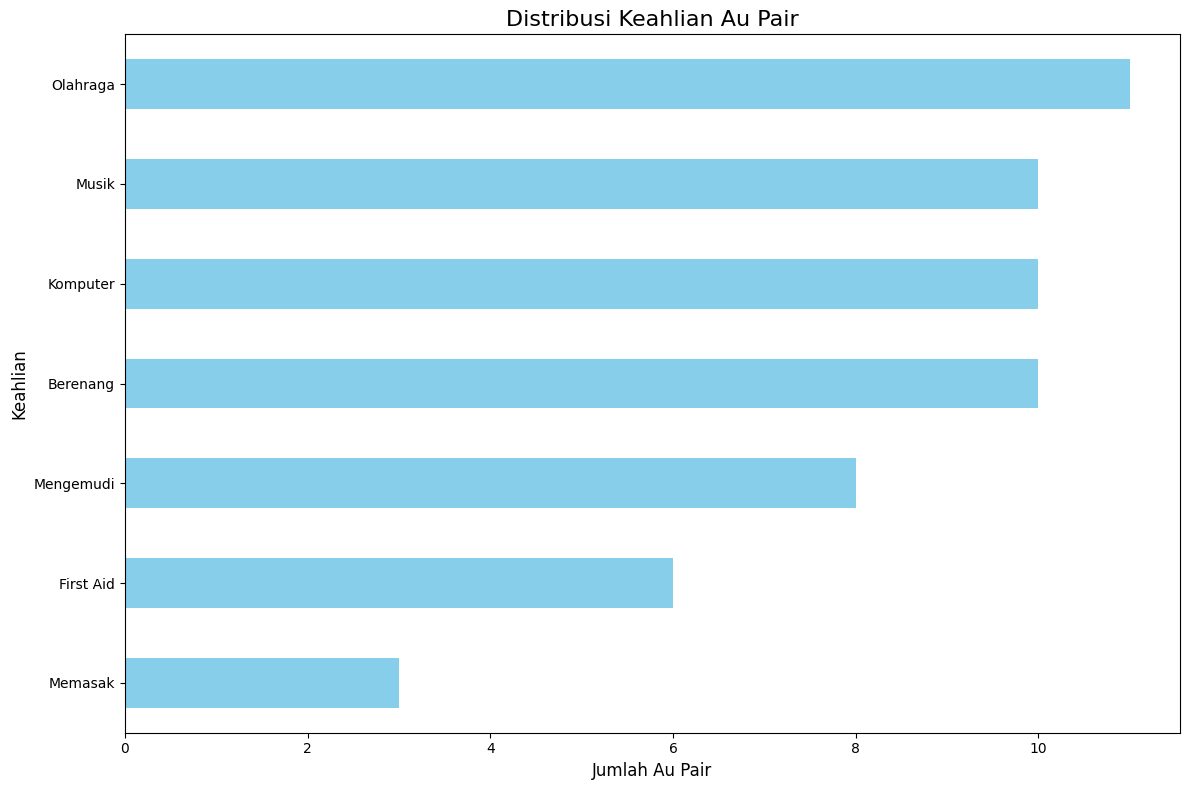


3. Building content-based filtering model...

=== Building Content-Based Filtering Model ===
Content-based model built successfully!
TF-IDF matrix shape: (20, 7)
Cosine similarity matrix shape: (20, 20)

4. Building collaborative filtering model...

=== Building Collaborative Filtering Model ===
Collaborative filtering model built successfully!
RMSE: 0.9416
MAE: 0.7804

5. Evaluating models...

=== Model Evaluation ===
RMSE: 0.9416
MAE:  0.7804

Collaborative Filtering Evaluation:
RMSE: 0.9416
MAE: 0.7804

6. Generating sample recommendations...


=== Recommendations for Keluarga Sutanto ===
Location: DKI Jakarta, Jakarta Selatan
Required skills: Memasak First-Aid Mengemudi
Budget: Rp 3,500,000

Collaborative Filtering Recommendations:
1. Rizki Aditya (21 tahun)
   Location: Jawa Timur
   Skills: First-Aid Mengemudi Komputer Olahraga
   Rating: 4.3

2. Rina Kartika (18 tahun)
   Location: Lampung
   Skills: Memasak First-Aid
   Rating: 4.6

3. Fitri Handayani (19 tahun)
   Location: S

In [6]:
# Example usage and testing
def main():
    """Main function to demonstrate the Au Pair Recommendation System"""

    print("=== AU PAIR RECOMMENDATION SYSTEM ===")
    print("Inspired by MovieLens approach for Indonesian Au Pair matching\n")

    # Initialize the system
    recommender = AuPairRecommendationSystem()

    # Load data
    print("1. Loading data...")
    recommender.load_data()

    # Preprocess data
    print("\n2. Preprocessing data...")
    recommender.preprocess_data()

    # Build content-based model
    print("\n3. Building content-based filtering model...")
    recommender.build_content_based_model()

    # Build collaborative filtering model
    print("\n4. Building collaborative filtering model...")
    recommender.build_collaborative_filtering_model()

    # Evaluate models
    print("\n5. Evaluating models...")
    recommender.evaluate_models()

    # Example recommendations
    print("\n6. Generating sample recommendations...")

    # Example 1: Recommendations for existing parent (by ID)
    print("\n" + "="*60)
    recommender.generate_recommendations(1, recommendation_type='hybrid', top_n=3)

    # Example 2: Recommendations based on custom requirements
    print("\n" + "="*60)
    custom_requirements = {
        'skills': ['Memasak', 'First-Aid'],
        'location': 'DKI Jakarta',
        'gender': 'Perempuan'
    }
    recommender.generate_recommendations(custom_requirements, recommendation_type='content', top_n=3)

    # Save model
    print("\n7. Saving model...")
    recommender.save_model()

    print("\n=== Au Pair Recommendation System Complete! ===")
    print("\nUsage examples:")
    print("- recommender.generate_recommendations(parent_id, 'hybrid', 5)")
    print("- recommender.generate_recommendations(requirements_dict, 'content', 3)")
    print("- recommender.save_model('my_model.pkl')")
    print("- recommender.load_model('my_model.pkl')")

if __name__ == "__main__":
    main()